# PRE
  - import packages 
  - connect google drive
  - set-up parameters
  - etc

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
HOME_DIR = '/content/drive/MyDrive/python/sound'
DATA_DIR = 'data'
MODULE_DIR = 'farms'
OUTPUT_DIR = 'out'
#search_size=21, neighbor_size=13
NEIGHBOR_SIZE = 9; SEARCH_SIZE = 128
#NEIGHBOR_SIZE = 9; SEARCH_SIZE = 51
#NEIGHBOR_SIZE = 103; SEARCH_SIZE = 201

In [8]:
os.chdir(HOME_DIR)

### git clone && git checkout dev && git fetch

In [6]:
!git clone https://github.com/hansgun/sound.git

fatal: destination path 'sound' already exists and is not an empty directory.


In [9]:
os.chdir('sound')

In [8]:
!git checkout dev
!ls

^C
data		   drive_code.ipynb	   pypy3.7-v7.3.4-linux64.tar.bz2
data_339_3.pickle  examples		   README.md
data_339_4.pickle  farms		   sound.ipynb
data_339.pickle    pypy3.7-v7.3.4-linux64  sound_v1.1.ipynb


In [9]:
!git fetch origin dev

^C


In [10]:
!git pull origin dev

^C


In [10]:
import sys
sys.path.append(MODULE_DIR)

# 1. DNS(Dominant Neighborhood Structure)

## Import UDC(user defined class)

In [11]:
import snd_dns_cal
import snd_loader

In [12]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Mar 15 17:54:34 2021

@author: han
"""

import os
from scipy.io import wavfile

class snd_loader : 
    def __init__(self, file_path, len_snd, interval_snd) :
        self.file_path = file_path
        try : 
            self.samplerate, self.test_sound  = wavfile.read(self.file_path)
            print(wavfile.read(self.file_path))
        except Exception : 
            print('Error::: not a vaild file path')

        self.len_snd = len_snd
        self.interval_snd = interval_snd

        
    def get_snd_df(self) :
        #print(len(self.test_sound))
        ind_num = int((len(self.test_sound) // self.samplerate - self.len_snd) // self.interval_snd)
        
        self.sliced = list([self.test_sound[i*self.interval_snd*self.samplerate:(i*self.interval_snd+self.len_snd)*self.samplerate, 0] for i in range(ind_num)])
        print('dns layer size :', len(self.sliced))
        return (self.samplerate, self.sliced)

'\nCreated on Mon Mar 15 17:54:34 2021\n\n@author: han\n'

In [13]:
wav_file_str = os.path.join(HOME_DIR, DATA_DIR, 'real.wav')

In [15]:
## params 
# wav file str, seconds to divide, intervals between matrix
samplerate, sliced = snd_loader(wav_file_str, 3, 1).get_snd_df()
samplerate

(44100, array([[  0,   0],
       [  0,   0],
       [  0,   0],
       ...,
       [139, 139],
       [313, 313],
       [279, 279]], dtype=int16))
dns layer size : 680


44100

In [16]:
len(sliced)

680

In [17]:
print(len(sliced))
print(sliced[0].shape)
print(pow(sliced[0].shape[0],1/2))

680
(132300,)
363.73066958946424


In [18]:
def normalization(test_sound_2d) : 
    min_val, max_val = np.min(test_sound_2d).astype(np.int32), np.max(test_sound_2d).astype(np.int32)
    return ((test_sound_2d - min_val) / (max_val - min_val) * 255).astype(int)

def reshape_snd_data(test_sound_2d_norm) :
    import math
    DIMEN_N = int(round(math.sqrt(test_sound_2d_norm.shape[1]),0)-1)
    DIMEN_N_2 = DIMEN_N**2
    ND_LIST = []
    #self.test_sound_2d = self.test_sound[:self.DIMEN_N_2].reshape(-1,self.DIMEN_N)
    for x in test_sound_2d_norm :
        #ND_LIST.append(x[:DIMEN_N_2].reshape((DIMEN_N,DIMEN_N), order='F'))
        ND_LIST.append(x[:DIMEN_N_2].reshape(-1,DIMEN_N))
    return ND_LIST
    #print('\n---------------test_sound_2d------------\n')
    #print(self.test_sound_2d)
    #print('\n---------------test_sound_2d------------\n')

## Compute DNS 

In [19]:
norm_sliced = normalization(sliced)
norm_sliced.shape

(680, 132300)

In [20]:
reshaped = reshape_snd_data(np.array(norm_sliced))
reshaped[0].shape
reshaped[0]
reshaped[1]

(363, 363)

array([[128, 128, 128, ..., 128, 128, 128],
       [128, 128, 128, ..., 128, 128, 128],
       [128, 128, 128, ..., 128, 128, 128],
       ...,
       [127, 126, 126, ..., 135, 135, 133],
       [133, 133, 132, ..., 128, 129, 130],
       [130, 132, 133, ..., 119, 119, 119]])

array([[136, 135, 134, ..., 128, 129, 131],
       [129, 128, 127, ..., 129, 128, 129],
       [129, 128, 129, ..., 136, 133, 129],
       ...,
       [139, 137, 133, ..., 118, 121, 124],
       [126, 127, 131, ..., 117, 116, 113],
       [115, 118, 116, ..., 129, 131, 130]])

In [21]:
 #search_size=21, neighbor_size=13
#NEIGHBOR_SIZE = 103; SEARCH_SIZE = 201
def get_pages(test_sound_2d, search_size = SEARCH_SIZE, neighbor_size = NEIGHBOR_SIZE) :
    '''
    전체 matrix를 계산할 sub-matrix 로 분할하여 그 리스트를 return 하는 함수
    '''
    ND_LIST = []
    ## calcluate n*n 의 갯수
    size_x, size_y = test_sound_2d[0].shape
    div_ = search_size + neighbor_size - 1
    ind_x, ind_y = size_x // div_, size_y // div_
    #cent_p = (div_ -1, div_ -1)
    result_list = []
    ## slicing
    for x in test_sound_2d : 
        for i in range(ind_x) : 
            for j in range(ind_y) : 
                ND_LIST.append(x[i*div_:(i+1)*div_,j*div_:(j+1)*div_])
        result_list.append(ND_LIST)
        ND_LIST = []
    #print(self.ND_LIST)
    return np.asarray(result_list)

In [22]:
paged_norm_sliced = get_pages(reshaped, search_size = SEARCH_SIZE, neighbor_size = NEIGHBOR_SIZE)
### list(ndarray)


print(paged_norm_sliced.shape)

(680, 4, 136, 136)


In [23]:
from numba import jit, njit

@njit
def distance_matrix(mat_x, search_win, search_size, neighbor_size):
    out = np.empty((search_size,search_size))
    for x_in in range(search_size) :
        for y_in in range(search_size) :
            out[x_in,y_in] = np.sqrt(
                np.sum(
                    (mat_x[x_in:x_in + neighbor_size, y_in:y_in + neighbor_size] - search_win) ** 2)
                )
    return out.reshape(search_size,search_size,1)


def cal_dns_mat(paged_norm_sliced,per_length,search_size=SEARCH_SIZE, neighbor_size=NEIGHBOR_SIZE, worker=1) :
    
    '''
    matrix array에 대한 dns 계산하여 np array (SEARCH_SIZE X SEARCH_SIZE X len(ND_LIST)) 를 return
    '''
    
    ### cent of matrix position 
    CENT_P = (search_size//2 + neighbor_size//2 , search_size//2 + neighbor_size//2 )
    
    ### result array
    result_mat = np.array([])
    return_result = np.zeros((search_size,search_size, paged_norm_sliced.shape[0]))
    ## for phase
    for ind_mat, x in enumerate(paged_norm_sliced) : ## number of nd_array
        if ind_mat % 100 == 0 : print(f'{ind_mat} of {len(paged_norm_sliced)}')
        for ind_inner, mat_x in enumerate(x) :
            search_win = mat_x[CENT_P[0]-(neighbor_size//2):CENT_P[0]+(neighbor_size//2)+1,
                            CENT_P[1]-(neighbor_size//2):CENT_P[1]+(neighbor_size//2)+1].copy()
            if ind_inner == 0 : result_mat = distance_matrix(mat_x, search_win, search_size, neighbor_size)
            else : result_mat = np.concatenate((result_mat, distance_matrix(mat_x, search_win, search_size, neighbor_size)), axis = 2)  
                 
        return_result[:,:,ind_mat] = np.mean(result_mat, axis=2)
    ## get a mean value of each cell finally
    return return_result

In [24]:
%%time
result = cal_dns_mat(np.asarray(paged_norm_sliced), per_length=len(paged_norm_sliced[0]))

0 of 680
100 of 680
200 of 680
300 of 680
400 of 680
500 of 680
600 of 680
CPU times: user 15.6 s, sys: 281 ms, total: 15.9 s
Wall time: 16 s


In [25]:
result.shape

(128, 128, 680)

In [26]:
result = result.transpose(2,0,1)

<Figure size 1440x720 with 0 Axes>

Text(0.5, 1.0, 'original')

Text(0.5, 1.0, 'original')

Text(0.5, 1.0, 'original')

Text(0.5, 1.0, 'original')

Text(0.5, 1.0, 'original')

Text(0.5, 1.0, 'original')

Text(0.5, 1.0, 'original')

Text(0.5, 1.0, 'original')

Text(0.5, 1.0, 'original')

Text(0.5, 1.0, 'original')

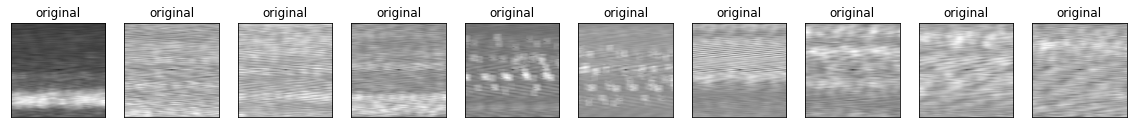

In [27]:
n = 10 ## 

plt.rcParams["figure.figsize"] = (100,4)
plt.figure(figsize=(20,10))

for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(result[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

## save dns results to pickle files

In [28]:
import pickle
# dim (680,21,21)
with open(os.path.join(HOME_DIR,'real_128_9-680.pickle'), 'wb') as f:
    pickle.dump(result, f, pickle.HIGHEST_PROTOCOL)

import pickle
with open('data_339_4.pickle', 'rb') as f:
    result_mat = pickle.load(f)

In [29]:
print(NEIGHBOR_SIZE)
print(SEARCH_SIZE)

9
128


# AutoEncoder 

## define autoencoder class

In [36]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping
latent_dim = SEARCH_SIZE ; image_dim = SEARCH_SIZE

class Autoencoder(Model):
  def __init__(self, latent_dim, image_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim 
    self.image_dim = image_dim  
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(32, activation='relu'), 
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(64, activation='relu'),    
      layers.Dense(128, activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(image_dim**2, activation='sigmoid'),
      layers.Reshape((self.image_dim, self.image_dim))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim, image_dim)

In [90]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping

class Autoencoder(Model):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(latent_dim, latent_dim, 1)), 
      #layers.Conv2D(16, (3,3), activation='relu', padding='same'), #strides=2),
      #layers.Conv2D(8, (3,3), activation='relu', padding='same'), #, strides=2)
      layers.Conv2D(16, (3,3), activation='relu', padding='same'), #strides=2),
      #layers.MaxPooling2D((2,2), padding='same'),
      layers.Conv2D(8, (3,3), activation='relu', padding='same'), #, strides=2)
      #layers.MaxPooling2D((2,2), padding='same'),
      ])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3,  activation='relu', padding='same'),
      #layers.UpSampling2D((2,2)),
      layers.Conv2DTranspose(16, kernel_size=3, activation='relu', padding='same'),
      #layers.UpSampling2D((2,2)),
      layers.Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder()

## set-up train, test data

In [54]:
from sklearn.model_selection import train_test_split
x_train, x_test = train_test_split(result, test_size=0.2, random_state=0)

In [55]:
#x_train = np.reshape(x_train, (len(x_train), SEARCH_SIZE, SEARCH_SIZE))
#x_test = np.reshape(x_test, (len(x_test), SEARCH_SIZE, SEARCH_SIZE))

In [56]:
x_train = np.array(x_train); x_test = np.array(x_test)

In [57]:
np.max(result)

1013.2147883629473

In [58]:
x_train = x_train.astype('float32')  / np.max(result) 
x_test = x_test.astype('float32') / np.max(result) 
#x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
#x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
#print(x_train[0])
print(x_train.shape, x_test.shape)

(544, 128, 128) (136, 128, 128)


In [59]:
np.max(x_train)

1.0

In [60]:
x_train, x_test = np.expand_dims(x_train, axis = 3),np.expand_dims(x_test, axis = 3)
print(x_train.shape, x_test.shape)

(544, 128, 128, 1) (136, 128, 128, 1)


## autoencoder compile && run

In [91]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [92]:
print(x_train.shape, x_test.shape)

(544, 128, 128, 1) (136, 128, 128, 1)


In [93]:
%%time
es = EarlyStopping(monitor='val_loss', mode='min', baseline=0.0002)
history = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test), 
                #callbacks=[es]
                )

Epoch 1/50
5/5 [==============================] - 26s 5s/step - loss: 0.1275 - val_loss: 0.1245
Epoch 2/50
5/5 [==============================] - 25s 5s/step - loss: 0.1145 - val_loss: 0.1054
Epoch 3/50
5/5 [==============================] - 25s 5s/step - loss: 0.0926 - val_loss: 0.0757
Epoch 4/50
5/5 [==============================] - 25s 5s/step - loss: 0.0624 - val_loss: 0.0392
Epoch 5/50
5/5 [==============================] - 25s 5s/step - loss: 0.0305 - val_loss: 0.0148
Epoch 6/50
5/5 [==============================] - 25s 5s/step - loss: 0.0173 - val_loss: 0.0127
Epoch 7/50
5/5 [==============================] - 25s 5s/step - loss: 0.0193 - val_loss: 0.0148
Epoch 8/50
5/5 [==============================] - 25s 5s/step - loss: 0.0208 - val_loss: 0.0149
Epoch 9/50
5/5 [==============================] - 25s 5s/step - loss: 0.0204 - val_loss: 0.0138
Epoch 10/50
5/5 [==============================] - 25s 5s/step - loss: 0.0189 - val_loss: 0.0123
Epoch 11/50
5/5 [======================

In [94]:
autoencoder.summary()

Model: "autoencoder_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_8 (Sequential)    (None, 128, 128, 8)       1320      
_________________________________________________________________
sequential_9 (Sequential)    (None, 128, 128, 1)       1897      
Total params: 3,217
Trainable params: 3,217
Non-trainable params: 0
_________________________________________________________________


In [95]:
autoencoder.encoder.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 128, 128, 16)      160       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 8)       1160      
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


## train-result... and visualization

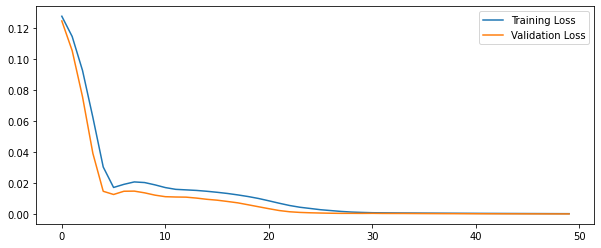

In [96]:
plt.rcParams["figure.figsize"] = (10,4)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

* threshold 값을 정하여 test 데이터에서 threshold 값을 넘어서는 데이터 조사

In [97]:
train_loss.shape

TensorShape([544, 128, 128])

(array([259., 166.,  46.,  19.,  17.,   2.,   9.,   6.,   3.,   0.,   1.,
          2.,   3.,   1.,   4.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          1.,   1.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([  96.442696,  133.5879  ,  170.73311 ,  207.87831 ,  245.02351 ,
         282.1687  ,  319.3139  ,  356.4591  ,  393.60434 ,  430.74954 ,
         467.89474 ,  505.03995 ,  542.1851  ,  579.3303  ,  616.4755  ,
         653.6207  ,  690.7659  ,  727.91113 ,  765.05634 ,  802.20154 ,
         839.34674 ,  876.49194 ,  913.6372  ,  950.7824  ,  987.9276  ,
        1025.0728  , 1062.218   , 1099.3632  , 1136.5084  , 1173.6536  ,
        1210.7988  , 1247.944   , 1285.0892  , 1322.2344  , 1359.3796  ,
        1396.5248  , 1433.67    , 1470.8152  , 1507.9604  , 1545.1056  ,
        1582.2509  , 1619.396   , 1656.5413  , 1693.6864  , 1730.8317  ,
 

Text(0.5, 0, 'Train loss')

Text(0, 0.5, 'No of examples')

Text(0.5, 1.0, 'train loss')

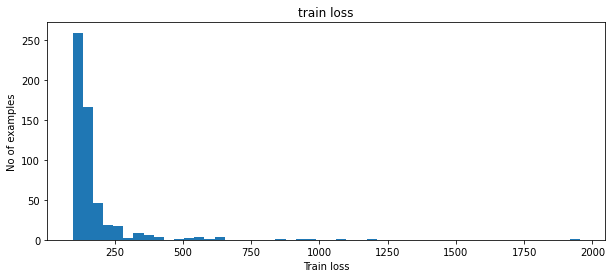

Threshold:  0.026612703


In [98]:
reconstructions_train = autoencoder.predict(x_train)
train_loss = tf.keras.losses.mae(reconstructions_train, x_train)

plt.hist(np.sum(train_loss,axis=(1,2)), bins=50)
#plt.hist(np.sum(train_loss,axis=(1)), bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.title("train loss")
plt.show()

threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

In [99]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

In [100]:
x_test_pred = autoencoder.predict(x_test)


(array([ 9., 11., 15., 15., 13., 14.,  8.,  7.,  3.,  5.,  6.,  5.,  2.,
         2.,  0.,  0.,  1.,  5.,  1.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  3.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  3.]),
 array([101.98502 , 107.72496 , 113.4649  , 119.204834, 124.94477 ,
        130.68471 , 136.42465 , 142.16458 , 147.90453 , 153.64445 ,
        159.3844  , 165.12433 , 170.86427 , 176.6042  , 182.34415 ,
        188.08408 , 193.82402 , 199.56395 , 205.3039  , 211.04382 ,
        216.78377 , 222.5237  , 228.26364 , 234.00357 , 239.74352 ,
        245.48344 , 251.22339 , 256.96332 , 262.70325 , 268.4432  ,
        274.18314 , 279.92307 , 285.663   , 291.40295 , 297.14288 ,
        302.8828  , 308.62274 , 314.3627  , 320.10263 , 325.84256 ,
        331.5825  , 337.32245 , 343.06238 , 348.8023  , 354.54224 ,
        360.2822  , 366.02213 , 371.76205 , 377.50198 , 383.24194 ,
        388.98187 ], dtype=float32),

Text(0.5, 0, 'Test MAE loss')

Text(0, 0.5, 'No of samples')

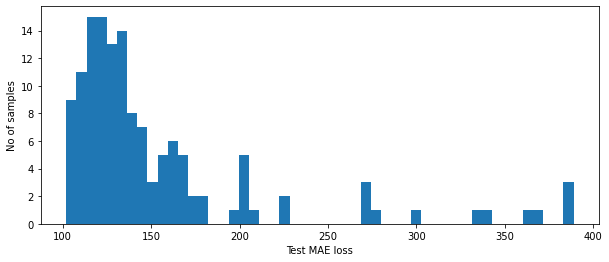

Reconstruction error threshold of test:  0.021359403


In [101]:
# Get train MAE loss.
plt.rcParams["figure.figsize"] = (10,4)
x_test_pred = autoencoder.predict(x_test)
test_mae_loss = tf.keras.losses.mae(x_test_pred, x_test)

plt.hist(np.sum(test_mae_loss,axis=(1,2)), bins=50)
#plt.hist(np.sum(test_mae_loss,axis=(1)), bins=50)
plt.xlabel("Test MAE loss")
plt.ylabel("No of samples")
plt.show()

threshold_test =  np.mean(test_mae_loss) + np.std(test_mae_loss)
print("Reconstruction error threshold of test: ", threshold_test)

In [102]:
x_test_mse = np.mean(np.abs(x_test_pred - x_test), axis=(1,2))
result_index = np.where(x_test_mse > threshold)[0]

## Plot model test results
*  
* 좀 더 loss 가 줄어들게 학습을 하던가 좀 더 복잡한 모델이 필요할 가.. 고민 중 

### testdata 의 결과를 plot(원본, decoded )

<Figure size 1440x576 with 0 Axes>

Text(0.5, 1.0, 'original')

Text(0.5, 1.0, 'reconstructed')

Text(0.5, 1.0, 'original')

Text(0.5, 1.0, 'reconstructed')

Text(0.5, 1.0, 'original')

Text(0.5, 1.0, 'reconstructed')

Text(0.5, 1.0, 'original')

Text(0.5, 1.0, 'reconstructed')

Text(0.5, 1.0, 'original')

Text(0.5, 1.0, 'reconstructed')

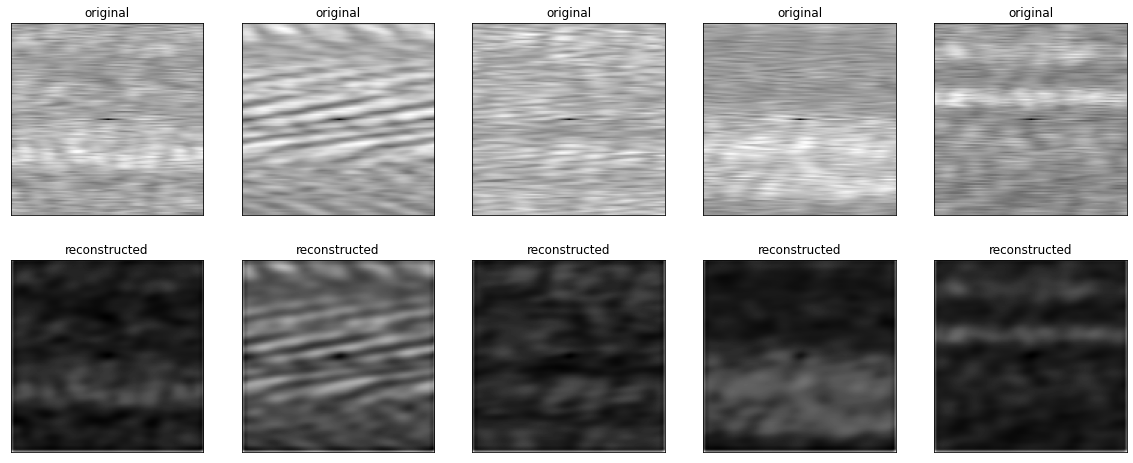

In [103]:
n = 5 ## 

plt.rcParams["figure.figsize"] = (100,4)
plt.figure(figsize=(20,8))

for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  #plt.imshow((x_test[i]))
  plt.imshow(np.squeeze(x_test[i], axis=2))
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(np.squeeze(decoded_imgs[i],axis=2))
  #plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [104]:
from IPython.display import Audio
test = np.squeeze(x_test[1], axis=2)
sliced[1].shape

(132300,)

In [105]:
result_index

array([], dtype=int64)

In [76]:
# normal
Audio(sliced[0],rate=samplerate)

In [87]:
### over the threshold
Audio(sliced[118],rate=samplerate)

### test 결과 중 threshold 값을 넘어서는 데이터를 plot

In [106]:
n = len(result_index)## 
print('num :', n)
plt.rcParams["figure.figsize"] = (200,4)
plt.figure(figsize=(20,8))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(np.squeeze(x_test[result_index[i]],axis=2))
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(np.squeeze(decoded_imgs[result_index[i]],axis=2))
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

num : 0


<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

* train data 에서 threshold 값을 이용하여 classify 시 반영 
* dns data 생성은 여전히 느림 - list를 array 변경 예정, 다른 algorithm 적용 --> numba 적용